In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv('./data/BBB_Selected332_most_abundant_30confs.csv', sep=';')
label = pd.read_csv('./data/bbb_332_ata.txt', header=None, sep=' ')
newdf = {}
for cname in df.columns:
    newdf[cname] = []
newdf['logBB'] = [] 
for name in label[0]:
    if df[df['Objects'].str.contains(name)].shape[0] == 0:
        print('Error: name not found in df', name)
        continue
    else:
        values = df[df['Objects'].str.contains(name)]
        if not (values.iloc[0,0].find('_c0') != -1):
            print('Error: _c0 not found in df', name)
            continue
        else:
            for cname in df.columns:
                newdf[cname].append(values[cname].values[0])
            newdf['logBB'].append(label[label[0] == name].iloc[0,1])
newdf = pd.DataFrame(newdf)
print(newdf.head())

# remove all NaN columns
newdf = newdf.dropna(axis=1)
print(newdf.shape)
            

Error: name not found in df phenylbutazone
Error: name not found in df N-(4-phenylthiazol-2-yl)-guanidine
Error: name not found in df alpha-(4-pyridyl-1-oxide)-N-tert-butylnitrone
Error: name not found in df 2-(2-fluoro-ethyl)-isothiourea
                 Objects        V        S        R        G         d  \
0           1-butanol_c0  257.000  209.719  1.22545  1.11121  0.288411   
1             benzene_c0  281.250  208.624  1.34812  1.00746  0.277731   
2  1,2-dichloroethane_c0  256.375  205.486  1.24765  1.08036  0.385992   
3             acetone_c0  210.250  184.011  1.14259  1.11636  0.276238   
4      salicylic_acid_c0  329.125  253.172  1.30000  1.15090  0.416598   

        W1       W2       W3       W4  ...        P4        P5    EMDIF  \
0  494.375  294.750  162.625   74.750  ...  0.166667  0.000000  3.90329   
1  403.000   48.875    0.000    0.000  ...  0.000000  0.000000  0.00000   
2  406.875   66.625    0.000    0.000  ...  0.000000  0.000000  1.50746   
3  408.000  236.

/tmp/ipykernel_1178807/3535696022.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if df[df['Objects'].str.contains(name)].shape[0] == 0:


In [2]:
# drop Objects column 
newdf = newdf.drop('Objects', axis=1)
print(newdf.shape)
corr_matrix = newdf.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
newdf = newdf.drop(newdf[to_drop], axis=1)
print(newdf.shape)
Y = newdf['logBB']
X = newdf.drop(['logBB', 'LgBB'], axis=1)

(327, 126)
(327, 62)


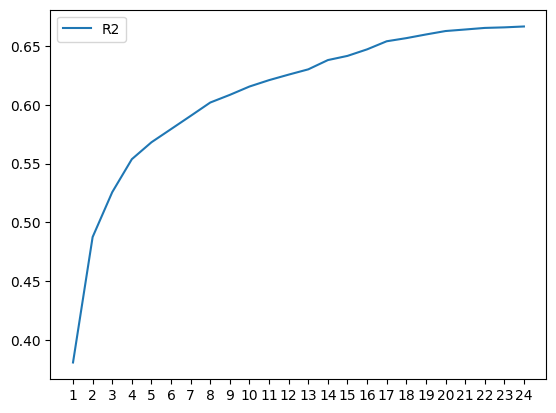

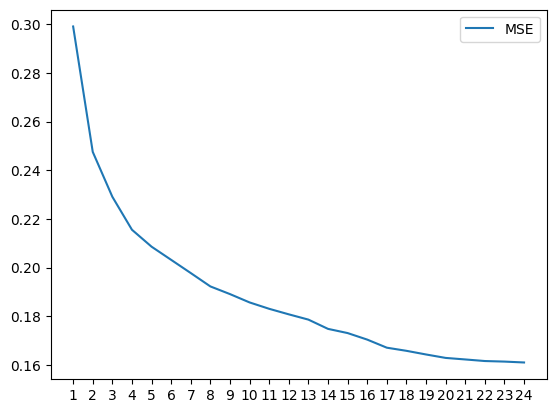

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, \
                                                random_state = 0)
mses = []
r2s = []
maxcomp = 25
for n in range(1, maxcomp):
    pls = PLSRegression(n_components=n)
    pls.fit(X_train, y_train)
    y_pred = pls.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)
    mses.append(mse)
    r2s.append(r2)

plt.plot(range(1, maxcomp), r2s, label='R2')
plt.xticks(range(1, maxcomp))
plt.legend()
plt.show()

plt.cla()
plt.plot(range(1, maxcomp), mses, label='MSE')
plt.xticks(range(1, maxcomp))
plt.legend()
plt.show()


In [4]:

pls = PLSRegression(n_components=22)
pls.fit(X_train, y_train)
y_pred_test = pls.predict(X_test)
msetest = mean_squared_error(y_test, y_pred_test)
r2test = r2_score(y_test, y_pred_test)

y_pred_train = pls.predict(X_train)
msetrain = mean_squared_error(y_train, y_pred_train)
r2train = r2_score(y_train, y_pred_train)

 MSE test:    0.12379
  R2 test:    0.76158
MSE train:    0.16161
 R2 train:    0.66540


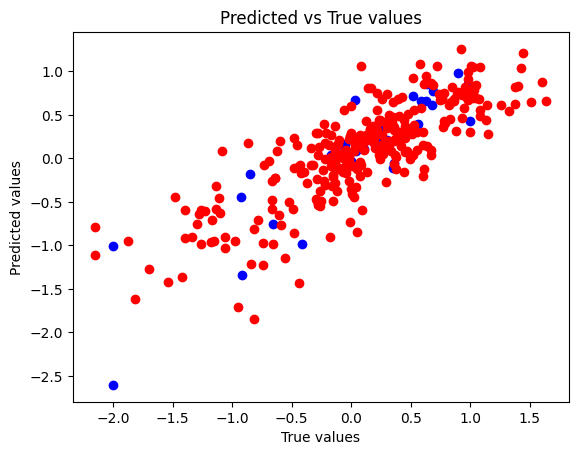

In [5]:
print(' MSE test: %10.5f'%(msetest))
print('  R2 test: %10.5f'%(r2test))
print('MSE train: %10.5f'%(msetrain))
print(' R2 train: %10.5f'%(r2train))
plt.scatter(y_test, y_pred_test, color='blue')
plt.scatter(y_train, y_pred_train, color='red')
plt.title('Predicted vs True values')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.show()

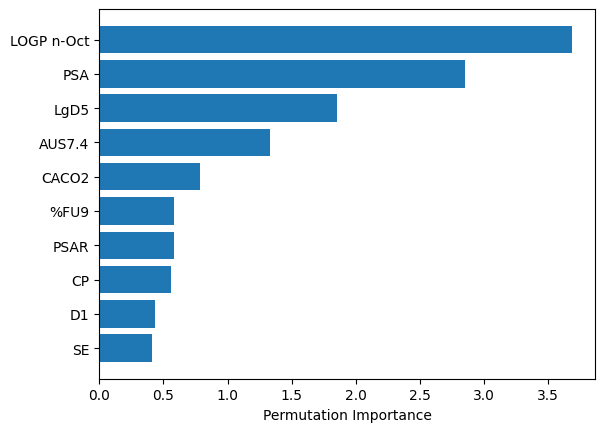

In [6]:
from sklearn.inspection import permutation_importance

result = permutation_importance(pls, X, Y, \
                                n_repeats=10, random_state=0, \
                                n_jobs=2, scoring='r2')
sorted_idx = result.importances_mean.argsort()
sorted_idx_most = sorted_idx[-10:]
#sorted_idx_most = sorted_idx_most[::-1]

plt.barh(X.columns[sorted_idx_most], \
         result.importances_mean[sorted_idx_most])
plt.xlabel('Permutation Importance')
plt.show()

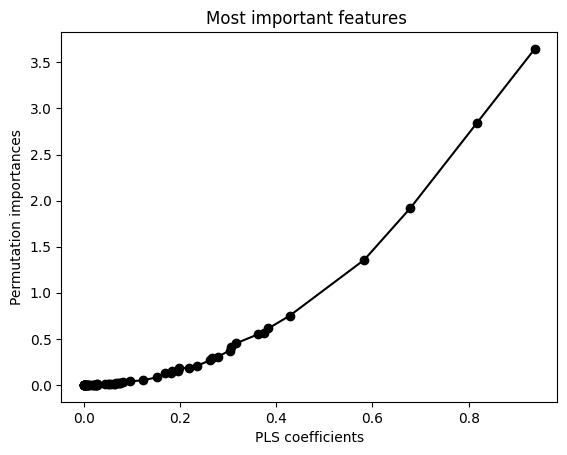

Most important features
                                                  LOGP n-Oct       0.94       3.65
                                                         PSA       0.82       2.84
                                                        LgD5       0.68       1.92
                                                      AUS7.4       0.58       1.36
                                                       CACO2       0.43       0.75
                                                        %FU9       0.38       0.61
                                                          CP       0.36       0.57
                                                        PSAR       0.38       0.55
                                                          D1       0.32       0.45
                                                          SE       0.31       0.41
                                                        SKIN       0.30       0.37
                                                       %FU10   

In [7]:
most_importante_features = []
result = permutation_importance(pls, X, Y, n_repeats=10, \
                                random_state=42, n_jobs=2,
                                scoring='r2')
pfi_sorted_idx = result.importances_mean.argsort()
#compute absolute values of the PLS coefficients
coef = np.abs(pls.coef_).flatten()
#sort the coefficients
sorted_idx = np.argsort(coef)

# scatter plot of the most important features
plt.clf()
plt.rcParams['figure.figsize'] = [8, 8]
fis = [np.mean(result.importances[i].T) for i in pfi_sorted_idx]
cfs = [coef[i] for i in sorted_idx]
plt.plot(cfs, fis, '-o', color='black')
plt.xlabel("PLS coefficients")
plt.ylabel("Permutation importances")
plt.title("Most important features ")
plt.show()

# print the most important features
features_names = X.columns
print("Most important features")
for i in reversed(pfi_sorted_idx):
    most_importante_features.append(features_names[i])
    print("%60s"%features_names[i], \
          "%10.2f"%coef[i], \
          "%10.2f"%np.mean(result.importances[i].T))